In [1]:
#Calculo del tiempo de resonancia
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count
import time
import logging

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525801E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.1      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0
tf= 10E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6; SE PUEDE CAMBIAR A 200
dt= 1000
ptol = 1e-10
kB = 1.38064E-23
e = -1.6E-19
num_cpus = 24
num_solution = 2
num_collisions = 5

logging.basicConfig(level=logging.INFO)

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t)) *ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t)) *iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t)) *ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results

if __name__ == '__main__':

    logging.info("Inicio de la ejecución")
    start_time = time.time()
    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))
    
    end_time = time.time()
    execution_time = (end_time - start_time)/60
    logging.info("Ejecución completada")
    print(f"Tiempo total de ejecución con 24 nucleos: {execution_time:.2f}minutos")

INFO:root:Inicio de la ejecución
INFO:root:Ejecución completada


Tiempo total de ejecución con 24 nucleos: 0.06minutos


Iniciales_ion: 0.0 0.0 0.0 0.0
Finales_ion: -1.7738401075397897e-09 -1.0719038645124056e-08 -0.002673638437811548 -0.0034328768375020587
Iniciales_atom: -6.173735875803346e-08 -3.970487076135445e-08 0.006272747820197147 0.039462811525086336
Finales_atom: -3.736820632253208e-08 -1.8254111526250034e-07 -0.010505439923624483 -0.007821586886281491
El átomo sale de la esfera en t = 1.4850002266e-06 s con interpolación


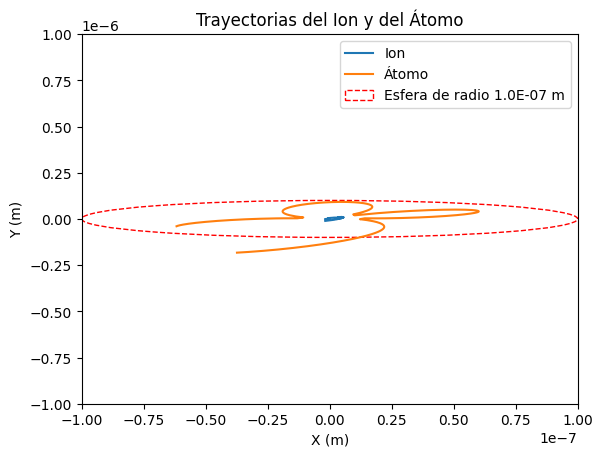

Iniciales_ion: -1.7738401075397897e-09 -1.0719038645124056e-08 -0.002673638437811548 -0.0034328768375020587
Finales_ion: 6.3748295556792114e-09 -4.848353090360451e-09 -0.001963284000653499 -0.007199826038278622
Iniciales_atom: 2.1527455182270513e-08 -6.31999797222315e-08 0.017612577137724218 -0.02917346913147715
Finales_atom: 4.4337255586708257e-07 -5.261134239208767e-07 0.04750512518731241 -0.05343639381312918
El átomo sale de la esfera en t = 1.8656183081e-06 s con interpolación


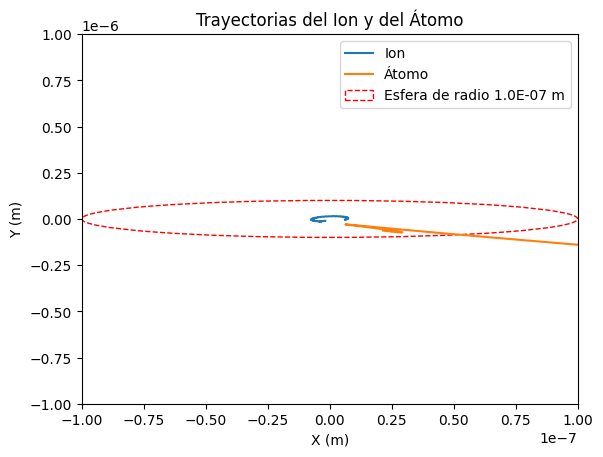

Iniciales_ion: 6.3748295556792114e-09 -4.848353090360451e-09 -0.001963284000653499 -0.007199826038278622
Finales_ion: 6.78589780752024e-09 1.885771374254381e-09 0.000615941524841302 -0.003347932840266251
Iniciales_atom: -3.90807370958736e-08 7.411871261930945e-08 0.002610179660162143 -0.01889012805468288
Finales_atom: 5.086911849145365e-09 7.42940827144801e-08 0.002699139652270908 -0.008396247334663345
El átomo sale de la esfera en t = 1.7620005179e-06 s con interpolación


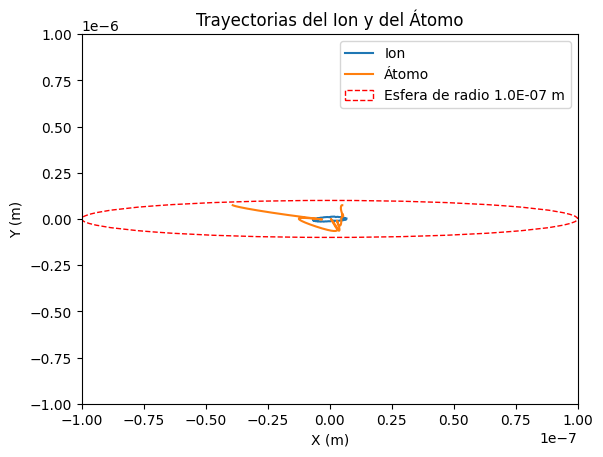

Iniciales_ion: 6.78589780752024e-09 1.885771374254381e-09 0.000615941524841302 -0.003347932840266251
Finales_ion: 1.519472753257967e-09 1.6706699374286997e-09 0.001916417244997263 -0.0027249098376815944
Iniciales_atom: 3.9790176314248486e-08 -8.554734902900977e-08 0.010378490463916118 0.010590494906069397
Finales_atom: -7.260838317007762e-08 2.619654716152137e-07 -0.01508224594768686 0.0420713336728479
El átomo sale de la esfera en t = 3.9122498210e-06 s con interpolación


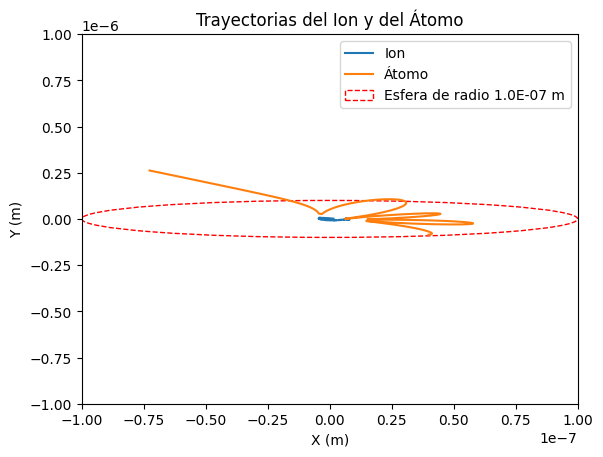

Iniciales_ion: 1.519472753257967e-09 1.6706699374286997e-09 0.001916417244997263 -0.0027249098376815944
Finales_ion: -1.3820162153373567e-09 4.150947806451403e-09 -8.330641746990826e-05 -0.00039899905560473277
Iniciales_atom: 3.0651624819054954e-09 7.876955271098475e-08 0.01495295478107802 -0.02260886666027763
Finales_atom: -1.0001763480876608e-08 -7.399427996143274e-08 -0.019503698639512748 0.0009611830151823543
El átomo sale de la esfera en t = 9.5407088884e-07 s con interpolación


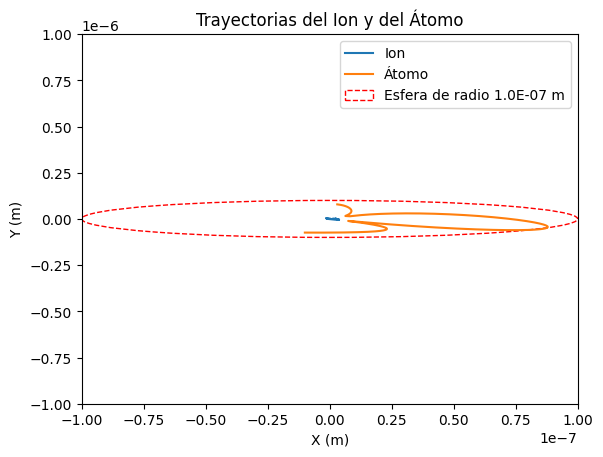

Iniciales_ion: 0.0 0.0 0.0 0.0
Finales_ion: 7.966077860794593e-10 -1.171938616848851e-09 -0.0007498759550017911 -0.0009912224257227632
Iniciales_atom: -6.173735875803346e-08 -3.970487076135445e-08 -0.0021728082864358065 0.0070371768510313
Finales_atom: 1.1596203490452496e-07 1.5744670610055317e-07 0.025144731120012094 0.03000743202950535
El átomo sale de la esfera en t = 1.5471957854e-06 s con interpolación


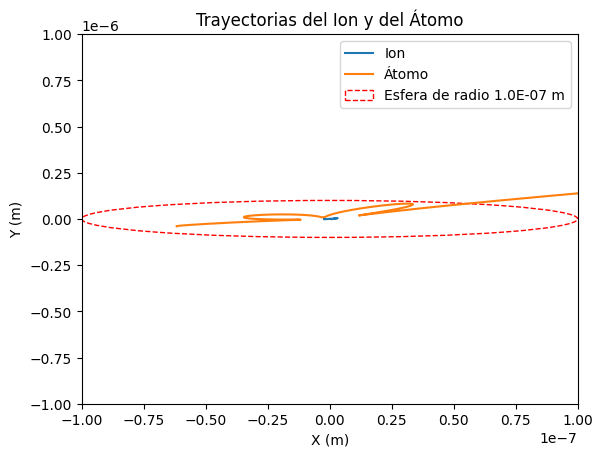

Iniciales_ion: 7.966077860794593e-10 -1.171938616848851e-09 -0.0007498759550017911 -0.0009912224257227632
Finales_ion: -4.396298557815345e-09 -8.520850707924729e-10 -0.0010723376245193469 -0.003249202916174362
Iniciales_atom: 2.1527455182270513e-08 -6.31999797222315e-08 0.02791863504817518 0.02780691502385079
Finales_atom: -9.557106681721935e-08 1.0631200739447421e-07 -0.0155547476884702 -0.0035119872693311497
El átomo sale de la esfera en t = 1.4122964344e-06 s con interpolación


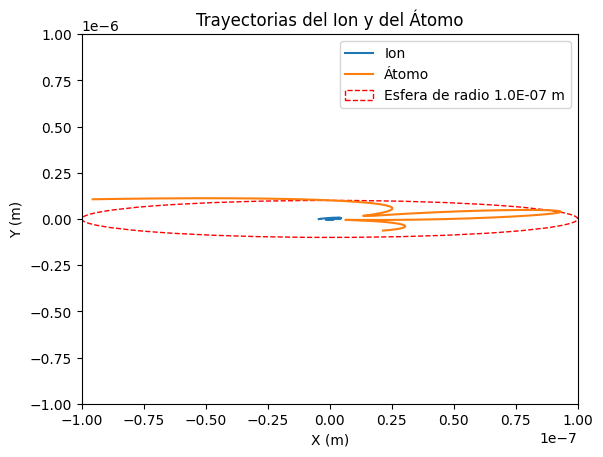

Iniciales_ion: -4.396298557815345e-09 -8.520850707924729e-10 -0.0010723376245193469 -0.003249202916174362
Finales_ion: 3.027055982278526e-10 3.0597569318208085e-09 -0.0024374115396486413 -0.001286876682152309
Iniciales_atom: -3.90807370958736e-08 7.411871261930945e-08 -0.019342657809468845 -0.025004773098916407
Finales_atom: 1.7469324472067565e-08 -4.7222823316320317e-07 0.007337682799060085 -0.05130376678201262
El átomo sale de la esfera en t = 1.4490726569e-06 s con interpolación


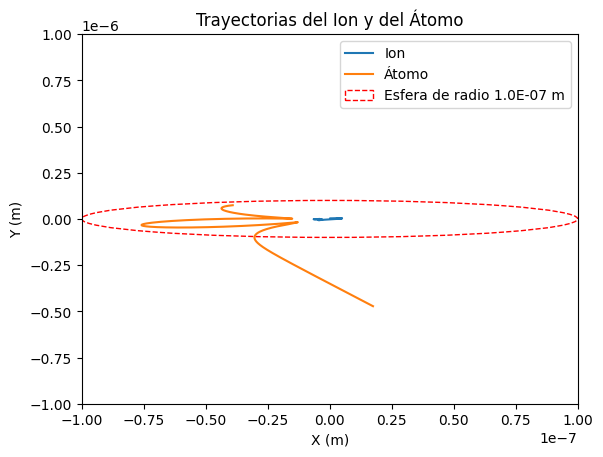

Iniciales_ion: 3.027055982278526e-10 3.0597569318208085e-09 -0.0024374115396486413 -0.001286876682152309
Finales_ion: 2.221829418952156e-09 3.5004690375678366e-09 -0.0008063610841196529 -0.002785738564631873
Iniciales_atom: 3.9790176314248486e-08 -8.554734902900977e-08 0.01258284505983983 0.01128894002109351
Finales_atom: -9.342993174842981e-08 1.240322513167707e-07 -0.0435401942193941 0.03868290046941892
El átomo sale de la esfera en t = 9.1616569603e-21 s con interpolación


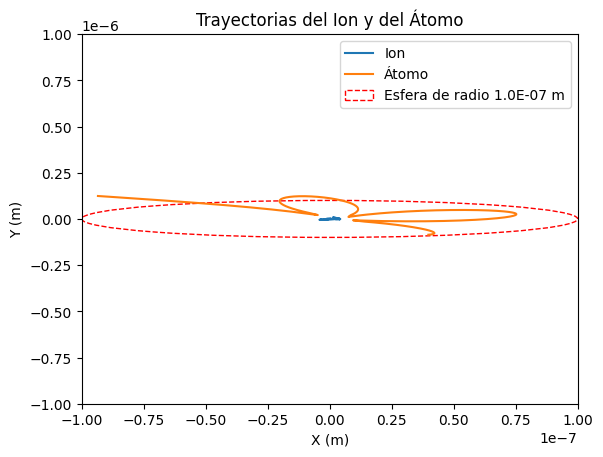

Iniciales_ion: 2.221829418952156e-09 3.5004690375678366e-09 -0.0008063610841196529 -0.002785738564631873
Finales_ion: 7.125091273347264e-10 1.3656022967059525e-08 5.653275655018584e-05 0.0033942668489731235
Iniciales_atom: 3.0651624819054954e-09 7.876955271098475e-08 0.003322881903659867 -0.020480632785739902
Finales_atom: 1.4561977844662887e-08 3.3286492110864724e-10 -0.00028783755975425856 -0.030864732301462874
El átomo sale de la esfera en t = 1.5224482324e-06 s con interpolación


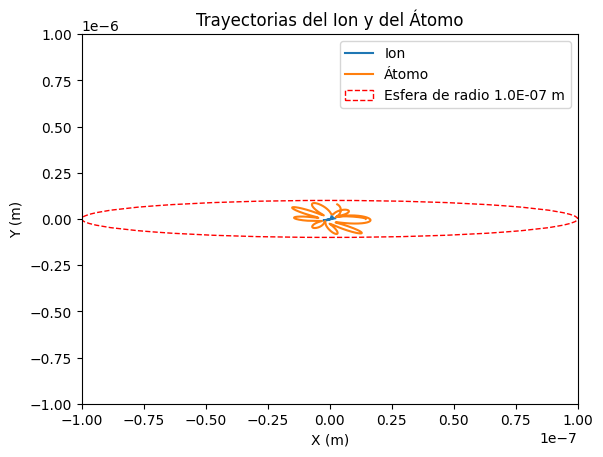

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define el radio de la esfera
r0 = 0.1E-6

# Bucle para iterar sobre todas las colisiones y trayectorias
for i, results in enumerate(all_results):   # cada colisión en el número de trayectorias
    for j, result in enumerate(results):    # parámetros de cada colisión
        t_sol = result[0]
        ionx_sol = result[1]
        iony_sol = result[2]
        ionz_sol = result[3]
        ionvx_sol = result[4]
        ionvy_sol = result[5]
        ionvz_sol = result[6]
        atomx_sol = result[7]
        atomy_sol = result[8]
        atomz_sol = result[9]
        atomvx_sol = result[10]
        atomvy_sol = result[11]
        atomvz_sol = result[12]

        # Graficar las trayectorias del ion y del átomo
        plt.plot(ionx_sol, iony_sol, label='Ion')
        plt.plot(atomx_sol, atomy_sol, label='Átomo')

        # Imprimir las condiciones iniciales y finales del ion y del átomo
        print('Iniciales_ion:', ionx_sol[0], iony_sol[0], ionvx_sol[0], ionvy_sol[0])
        print('Finales_ion:', ionx_sol[-1], iony_sol[-1], ionvx_sol[-1], ionvy_sol[-1])
        print('Iniciales_atom:', atomx_sol[0], atomy_sol[0], atomvx_sol[0], atomvy_sol[0])
        print('Finales_atom:', atomx_sol[-1], atomy_sol[-1], atomvx_sol[-1], atomvy_sol[-1])

        # Graficar la esfera de radio r0 alrededor de (0,0)
        circle = plt.Circle((0, 0), r0, color='r', fill=False, linestyle='--', label=f'Esfera de radio {r0:.1E} m')
        plt.gca().add_artist(circle)

        # Cálculo de la distancia entre el átomo y el origen (0, 0, 0)
        salida_times = []  # Lista para almacenar los tiempos de salida del átomo de la esfera
        for k in range(1, len(t_sol)):
            r_anterior = np.sqrt(atomx_sol[k-1]**2 + atomy_sol[k-1]**2 + atomz_sol[k-1]**2)
            r_actual = np.sqrt(atomx_sol[k]**2 + atomy_sol[k]**2 + atomz_sol[k]**2)
            
            if r_anterior < r0 and r_actual >= r0:
                # Interpolación lineal para obtener el tiempo más preciso de cruce
                t_salida = t_sol[k-1] + (r0 - r_anterior) / (r_actual - r_anterior) * (t_sol[k] - t_sol[k-1])
                salida_times.append(t_salida)
                print(f'El átomo sale de la esfera en t = {t_salida:.10e} s con interpolación')
                break

        # Configuración de límites y etiquetas del gráfico
        plt.xlim(-1E-7, 1E-7)
        plt.ylim(-1E-6, 1E-6)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.legend()
        plt.title('Trayectorias del Ion y del Átomo')

        # Mostrar la gráfica
        plt.show()


Iniciales: 0.0 0.0 0.0 0.0
Finales: -1.5994373467536689e-09 2.9075275692337734e-09 0.0016469389402299162 -0.0002252902205190047
Tiempo_resonancia


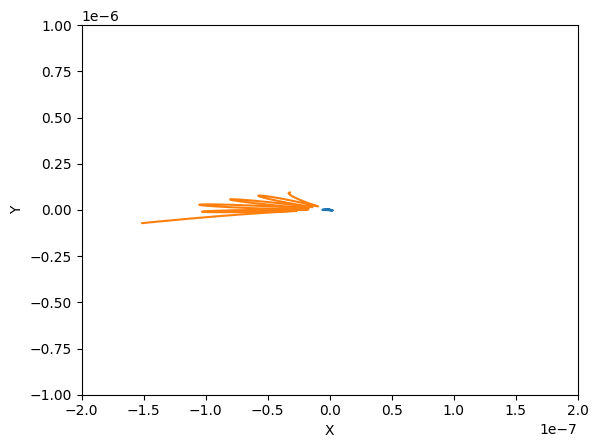

Iniciales: -1.5994373467536689e-09 2.9075275692337734e-09 0.0016469389402299162 -0.0002252902205190047
Finales: -2.0275015744445403e-09 7.509535753563858e-10 -0.00036818429709491326 0.002775949020153108
Tiempo_resonancia


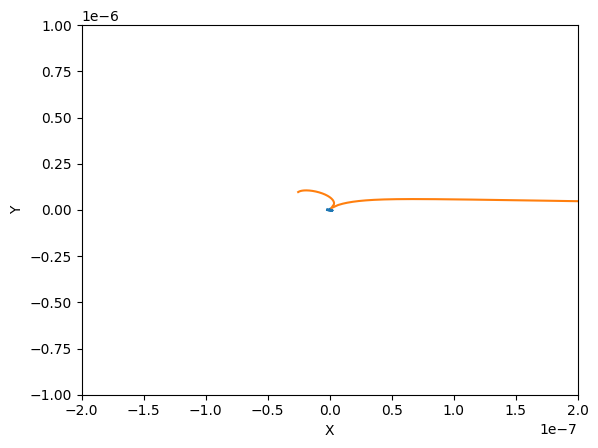

Iniciales: -2.0275015744445403e-09 7.509535753563858e-10 -0.00036818429709491326 0.002775949020153108
Finales: -3.2068723353453656e-09 -4.5600303682870324e-09 -0.0018864450167169501 0.0018839912107906603
Tiempo_resonancia


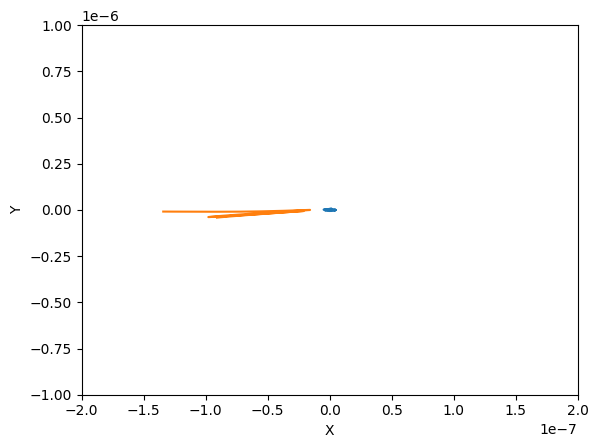

Iniciales: -3.2068723353453656e-09 -4.5600303682870324e-09 -0.0018864450167169501 0.0018839912107906603
Finales: 3.189868699169862e-10 -5.647566283384179e-09 -0.002800857820004224 -0.0015635549810532607
Tiempo_resonancia


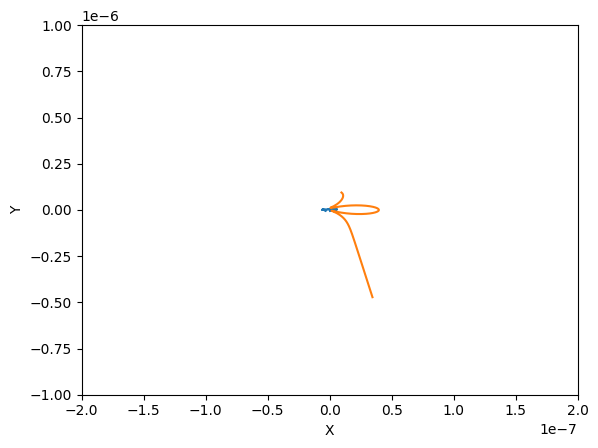

Iniciales: 3.189868699169862e-10 -5.647566283384179e-09 -0.002800857820004224 -0.0015635549810532607
Finales: -4.233027108954525e-09 -2.0047842579329945e-09 -0.0036733887522313663 -0.004367225507224403
Tiempo_resonancia


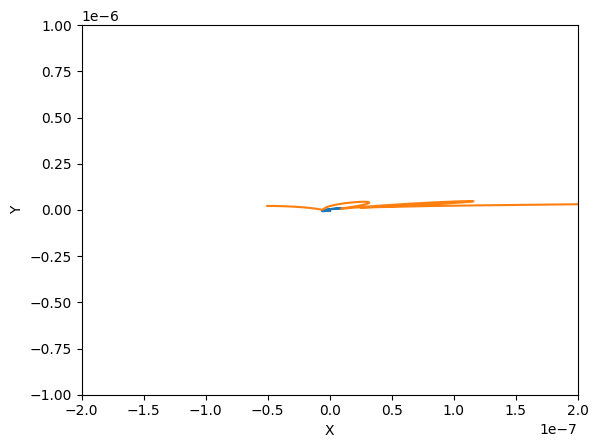

Iniciales: 0.0 0.0 0.0 0.0
Finales: 9.004293458456821e-10 -3.063142549416391e-09 0.000920833792344905 -0.0026538872025108603
Tiempo_resonancia


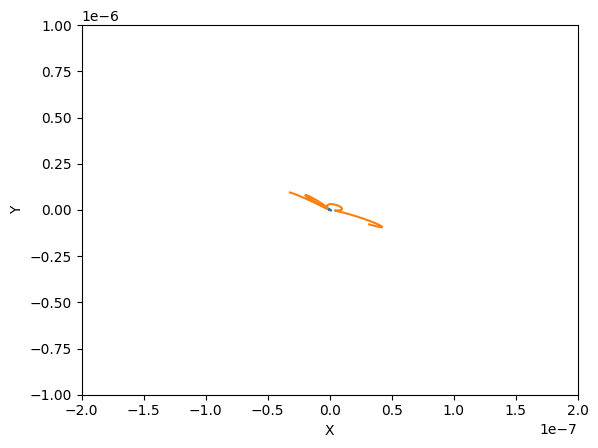

Iniciales: 9.004293458456821e-10 -3.063142549416391e-09 0.000920833792344905 -0.0026538872025108603
Finales: -1.916611874423618e-09 2.964873575373971e-09 0.0007119658504612198 0.0004455936016242572
Tiempo_resonancia


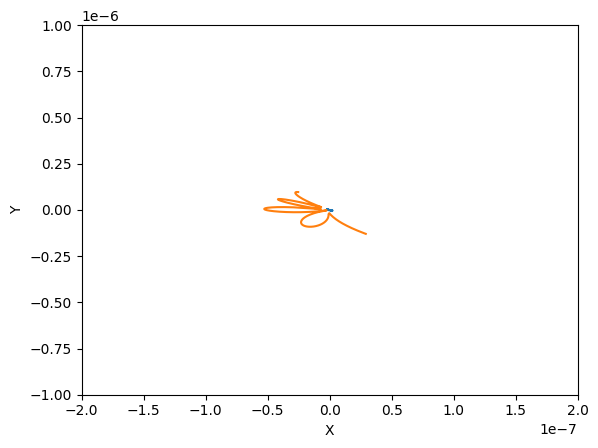

Iniciales: -1.916611874423618e-09 2.964873575373971e-09 0.0007119658504612198 0.0004455936016242572
Finales: -4.1728997105816185e-09 1.5879084995434394e-09 0.00042706798838940086 0.0016234191112228461
Tiempo_resonancia


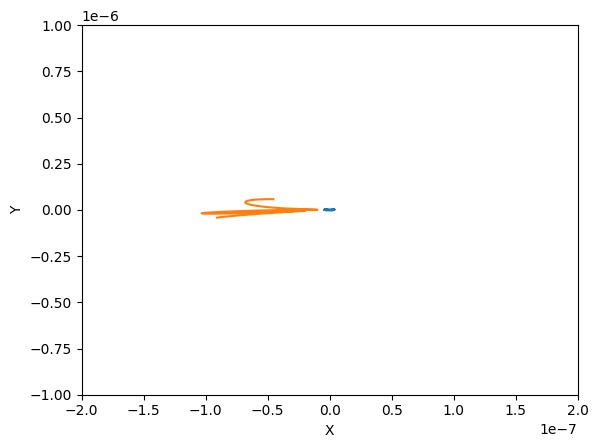

Iniciales: -4.1728997105816185e-09 1.5879084995434394e-09 0.00042706798838940086 0.0016234191112228461
Finales: -4.565628500882565e-09 -5.998206071258546e-09 -0.00188399605567238 0.005659919139219604
Tiempo_resonancia


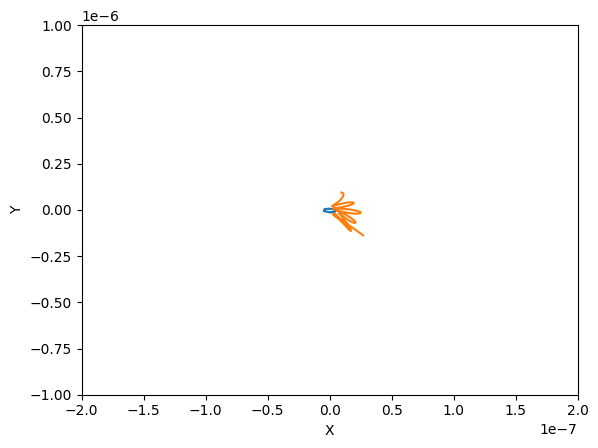

Iniciales: -4.565628500882565e-09 -5.998206071258546e-09 -0.00188399605567238 0.005659919139219604
Finales: -9.951900908085373e-10 -9.995806301487539e-09 -0.005453357583779423 0.0022495849234023335
Tiempo_resonancia


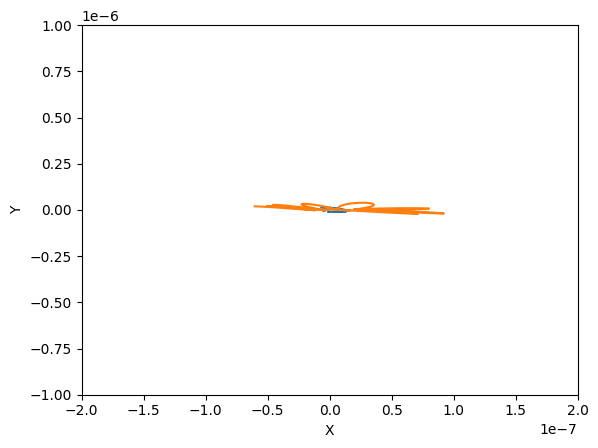

In [16]:
def radio (x, y, z):
    radio = math.sqrt(x**2 + y**2 + z**2)
    return radio 


for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
    for j, result in enumerate (results):     #parametros de cada colision
        t_sol=result[0]
        ionx_sol=result[1]
        iony_sol=result[2]
        ionz_sol=result[3]
        ionvx_sol=result[4]
        ionvy_sol=result[5]
        ionvz_sol=result[6]
        atomx_sol=result[7]
        atomy_sol=result[8]
        atomz_sol=result[9]
        atomvx_sol=result[10]
        atomvy_sol=result[11]
        atomvz_sol=result[12]

        plt.plot(ionx_sol, iony_sol)
        print('Iniciales:', ionx_sol[0], iony_sol[0], ionvx_sol[0], ionvy_sol[0] )
        print('Finales:', ionx_sol[-1], iony_sol[-1], ionvx_sol[-1], ionvy_sol[-1])
        print("Tiempo_resonancia", )
        plt.plot(atomx_sol, atomy_sol)
        plt.xlim(-2E-7, 2E-7)
        plt.ylim(-1E-6, 1E-6)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

In [ ]:
#Debe graficarse en relación al tiempo
R = []
for i in range(1000):
  R.append(np.sqrt((atomx_sol[i] - ionx_sol[i])**2 + (atomy_sol[i] - iony_sol[i])**2 + (atomz_sol[i] - ionz_sol[i])**2))

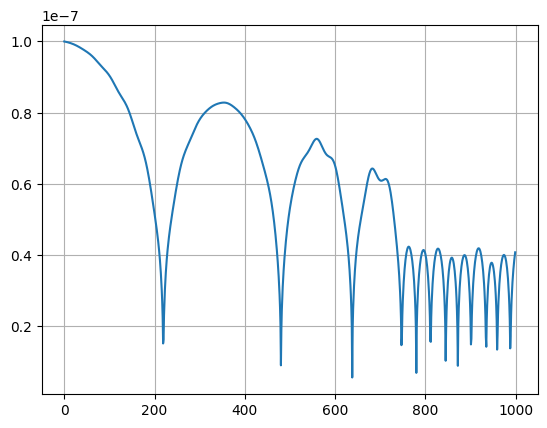

In [ ]:

plt.plot(R)
plt.grid()

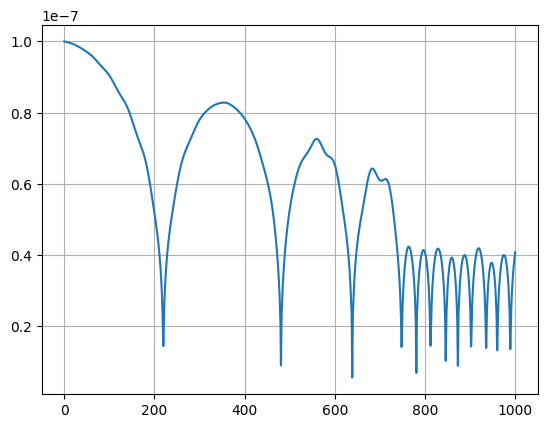

In [ ]:
from scipy.interpolate import CubicSpline
x_grid = np.linspace(0,1000,1000)
R_t = CubicSpline(x_grid,R)
x_grid2 = np.linspace(0,1000,1000000)
R2 = R_t(x_grid2)
plt.plot(x_grid2, R2)
plt.grid()

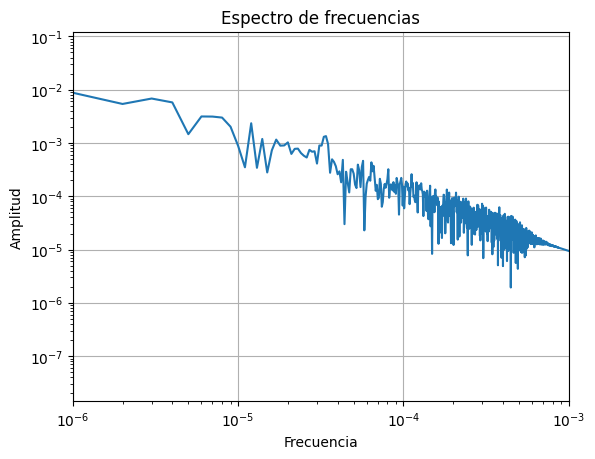

In [ ]:
#AAplicación FFT
N = len(R2)
y_fft= np.fft.fft(R2)
x_fft= np.fft.fftfreq(len(R2))[:N//2]

#Graficas en dominio de frecuencias
plt.plot(x_fft, np.abs(y_fft[:N//2]))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1e-3)
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencias')
plt.grid()
plt.show()

In [17]:
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from multiprocessing import Pool, cpu_count
import time
import logging

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+)
m_atom = 1.1525801E-26 # (Litio)
C4=5.607E-57  
C6=5E-19 * C4   
frf = 2.5 * 10**6
Omega = 2 * np.pi * frf
a = -2.982E-4  
q = 0.1       
T_ion = 0    
T_atom = 0.1E-6 
r0 = 0.1E-6  # Radio de la esfera
ti = 0
tf = 10E-6   
dt = 1000
ptol = 1e-10
num_cpus = 24
num_solution = 10
num_collisions = 500

logging.basicConfig(level=logging.INFO)

def system(t, y, a, q, Omega, C4, C6, m_ion, m_atom):
    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y
    dydt = np.zeros_like(y)
    
    # Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    # Velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    # Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t)) * ionx * (Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t)) * iony * (Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t)) * ionz * (Omega**2 / 4)

    # Interacción entre ion y átomo
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)
    
    dydt[3] += -(2*C4/r**5 - 6*C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 - 6*C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 - 6*C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 - 6*C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 - 6*C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 - 6*C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

# Funciones auxiliares
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass):
    kb = 1.380649e-23
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    v_x = v_r * np.sin(theta) * np.cos(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi)
    v_z = v_r * np.cos(theta)
    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

# Vector de tiempo
t_span = (ti, tf)

# Simulación
def run_simulation(i):

    ionx_0, iony_0, ionz_0 = 0.0, 0.0, 0.0
    ionvx_0, ionvy_0, ionvz_0 = velocidad_ion(T_ion, m_ion), velocidad_ion(T_ion, m_ion), velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    salida_times = []

    for collision in range(num_collisions):
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        ionx_sol, iony_sol, ionz_sol = solution.y[0], solution.y[1], solution.y[2]
        atomx_sol, atomy_sol, atomz_sol = solution.y[6], solution.y[7], solution.y[8]
        t_sol = solution.t

        for k, t in enumerate(t_sol):
            r = np.sqrt((atomx_sol[k] - ionx_sol[k])**2 + (atomy_sol[k] - iony_sol[k])**2 + (atomz_sol[k] - ionz_sol[k])**2)
            if r >= r0:
                salida_times.append(t)
                break  # Salir del bucle una vez que el átomo sale de la esfera

        # Actualizar condiciones iniciales para la siguiente colisión
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return salida_times

if __name__ == '__main__':
    logging.info("Inicio de la ejecución")
    start_time = time.time()

    with Pool(processes=num_cpus) as pool:
        all_salida_times = pool.map(run_simulation, range(num_solution))

    # Unir los resultados de todas las simulaciones
    all_times = [time for sublist in all_salida_times for time in sublist]

    # Calcular el tiempo medio y la desviación estándar
    mean_time = np.mean(all_times)
    std_dev_time = np.std(all_times)

    print(f"Tiempo medio de salida: {mean_time:.2e


SyntaxError: unterminated string literal (detected at line 138) (4290910553.py, line 138)

In [ ]:
#Cambiando Q=0.05 roja
#Con radiofrecuencia de 4.5 * np.pi * 10**6 q=0.1 (#13 minutos)
#C6= 5.607E-56
#q= 0.1
#Le alta estructura a la trampa para el ion en relación al
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count
import time
import logging

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57 #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2.0 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.05    #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0.0
tf= 200E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6;
dt= 10000
ptol = 1e-10
kB = 1.38064E-23
num_cpus = 24
num_solution = 5
num_collisions = 10

logging.basicConfig(level=logging.INFO)

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t))*ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t))*iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t))*ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

#Colision se detiene si átomo sale de segunda esfera de radio 2E-7
def event_condition(t, y, a, q, Omega, C4, C6, m_ion, m_a):
    # Definir condición de evento
    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y
    s = np.sqrt((atomx)**2 + (atomy)**2 + (atomz)**2)
    return s - 2.0E-6  #0.1E-6

# Indicar que el evento se debe buscar a través del cruce con cero
event_condition.terminal = True
event_condition.direction = 1

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        salida_times = []

        for k, t in enumerate(t_sol):
            r = np.sqrt((atomx_sol[k] - ionx_sol[k])**2 + (atomy_sol[k] - iony_sol[k])**2 + (atomz_sol[k] - ionz_sol[k])**2)
            if r >= r0:
                salida_times.append(t)
                break  # Salir del bucle una vez que el átomo sale de la esfera

        #results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])
        
        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return salida_times


if __name__ == '__main__':

    logging.info("Inicio de la ejecución")
    start_time = time.time()

    with Pool(processes=num_cpus) as pool:
        all_salida_times = pool.map(run_simulation, range(num_solution))
    #print(all_results)

    end_time = time.time()
    execution_time = (end_time - start_time)/60
    logging.info("Ejecución completada")
    print(f"Tiempo total de ejecución con 12 nucleos: {execution_time:.2f}minutos")
    #Ekin_total = []
    #for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
        Ekin_colision = []
        for j, result in enumerate (results):     #parametros de cada colision
            t_sol=result[0]
            ionx_sol=result[1]
            iony_sol=result[2]
            ionz_sol=result[3]
            ionvx_sol=result[4]
            ionvy_sol=result[5]
            ionvz_sol=result[6]
            atomx_sol=result[7]
            atomy_sol=result[8]
            atomz_sol=result[9]
            atomvx_sol=result[10]
            atomvy_sol=result[11]
            atomvz_sol=result[12]

            E_kin = 0.5 * m_ion * (ionvx_sol**2 + ionvy_sol**2 + ionvz_sol**2)
            Tkin = np.mean(0.5 * m_ion * (ionvx_sol[1:]**2 + ionvy_sol[1:]**2 + ionvz_sol[1:]) * (t_sol[1:] - t_sol[:-1]) / (t_sol[-1] - t_sol[0]) * (len(t_sol) - 1)) * 1 / (3/2 * kB) * 1e6
            Ekin_colision.append(Tkin)
            t_mean = np.mean(t_sol)
            t_max = max(t_sol)  # Maximum value of the time array
            E_max = max(E_kin)  # Maximum value of the kinetic energy array
        Ekin_total.append(Ekin_colision)

    Ekin_total_promedio = np.mean(Ekin_total, axis=0)
    #plt.text(0.95, 0.95, '(a)', transform=plt.gca().transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
    #print("Ekin_total_promedio", Ekin_total_promedio)

# Definir el rango máximo
#umbral_maximo = 20 # Ajusta este valor según tu necesidad

# Filtrar los datos por debajo del umbral máximo
#indices_validos = np.where(Ekin_total_promedio < umbral_maximo)
#Ekin_filtrado = np.array(Ekin_total_promedio)[indices_validos]
#num_collisiones_filtrado = np.arange(len(Ekin_total_promedio))[indices_validos]

# Graficar los datos filtrados
#plt.plot(num_collisiones_filtrado, Ekin_filtrado, label='Energía Cinética Promedio Filtrada')
#plt.title('Energía Cinética Promedio Filtrada por Número de Colisiones')
#plt.xlabel('Número de Colisiones')
#plt.ylabel('Energía Cinética Promedio (μK)')
#plt.grid()
#plt.legend()
#plt.show()